# Autoencoders

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import torchvision.transforms.functional as TF
from torch.optim import SGD, AdamW
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *
from operator import itemgetter
import fastcore.all as fc
from torch.utils.data import DataLoader

torch.manual_seed(42)

<torch._C.Generator>

In [ ]:
bs =64

In [ ]:
ds = load_dataset("anubhavmaity/notMNIST"); ds

DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3745
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14979
    })
})

In [ ]:
x, y = 'image', 'label'

In [ ]:
ds['train'][x][0]

In [ ]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [ ]:
tds = ds.with_transform(transformi)

In [ ]:
tds['train'][0][x].shape, tds['train'][0][y]

(torch.Size([1, 28, 28]), 6)

In [ ]:
train_dl, valid_dl = get_dls(tds['train'], tds['test'], bs, collate_fn=collate_dict(tds['train']))

In [ ]:
xb, yb = next(iter(train_dl));
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [ ]:
xb[0][0].shape

torch.Size([28, 28])

In [ ]:
upsample = nn.UpsamplingNearest2d(scale_factor = 2)
upsample(xb).shape

torch.Size([64, 1, 56, 56])

In [ ]:
def deconv(ni, nf, ks=3, stride=1, act=True):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor = 2),
        conv(ni, nf, ks, stride=stride, act=act)
    )

In [ ]:
autoencoder = nn.Sequential(
                nn.ZeroPad2d(2),
                conv(1, 2), # 16 x 16
                conv(2, 4), # 8 x 8
                conv(4, 8), # 4 x 4
                deconv(8, 4), # 8 x 8
                deconv(4, 2), # 16 x 16
                deconv(2, 1), # 32 x 32
                nn.ZeroPad2d(-2),
                nn.Sigmoid()
)

In [ ]:
autoencoder(xb).shape

torch.Size([64, 1, 28, 28])

In [ ]:
opt_func = AdamW(autoencoder.parameters(), lr = 0.1)

In [ ]:
def eval(model, loss_func, dl):
    losses = []
    total_count = 0
    model.eval()
    with torch.no_grad():
        for xb, _ in dl:
            n = len(xb)
            total_count += n
            pred_xb = model(xb)
            loss = loss_func(pred_xb, xb).item()
            losses.append(loss * n)
    print(f'Loss: {(sum(losses) / total_count): .2f}')

In [ ]:
eval(autoencoder, F.mse_loss, valid_dl)

Loss:  0.22


In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for i in range(epochs):
        model.train()
        for xb, _ in train_dl:
            pred_xb = model(xb)
            loss = loss_func(pred_xb, xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        print(f'Epoch {i}')
        eval(model, loss_func, valid_dl)

In [ ]:
fit(5, autoencoder, F.mse_loss, opt_func, train_dl, valid_dl)

Epoch 0
Loss:  0.22
Epoch 1
Loss:  0.22
Epoch 2
Loss:  0.22
Epoch 3
Loss:  0.22
Epoch 4
Loss:  0.22


In [ ]:
p = autoencoder(xb)

In [ ]:
p.shape

torch.Size([64, 1, 28, 28])

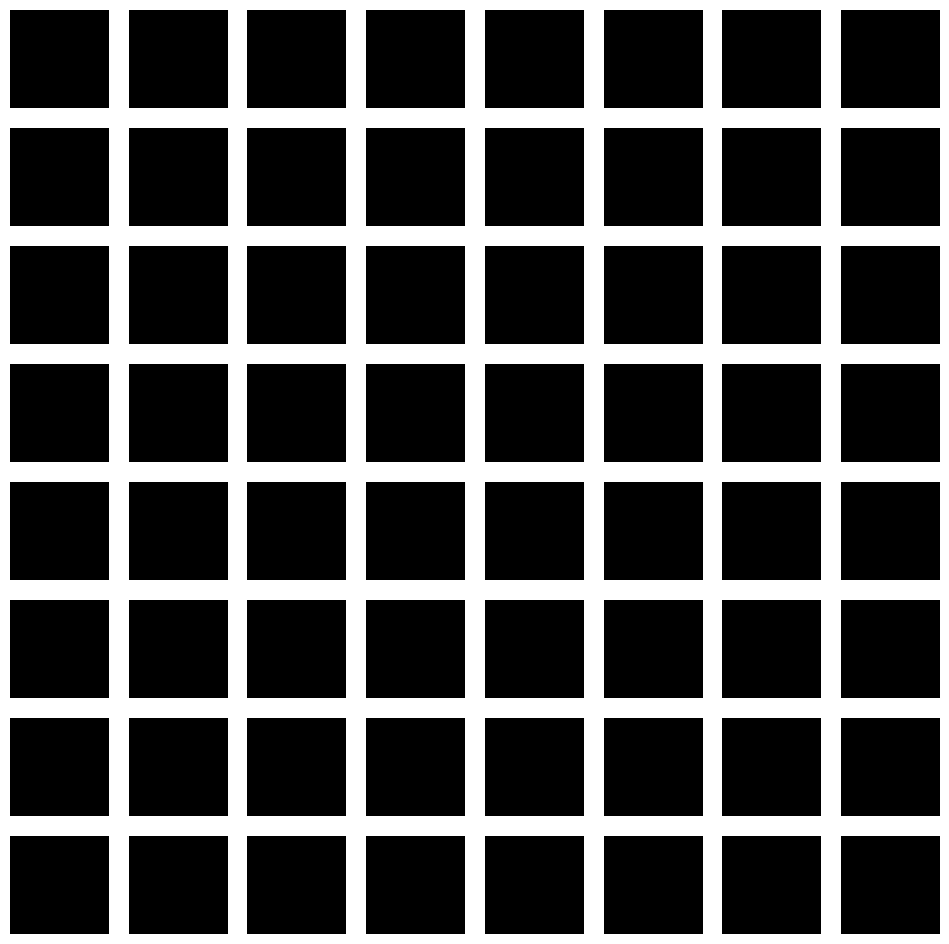

In [ ]:
show_images(p, imsize=1.5)

In [ ]:
lbl = tds['train'].features[y].names
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(lbl)

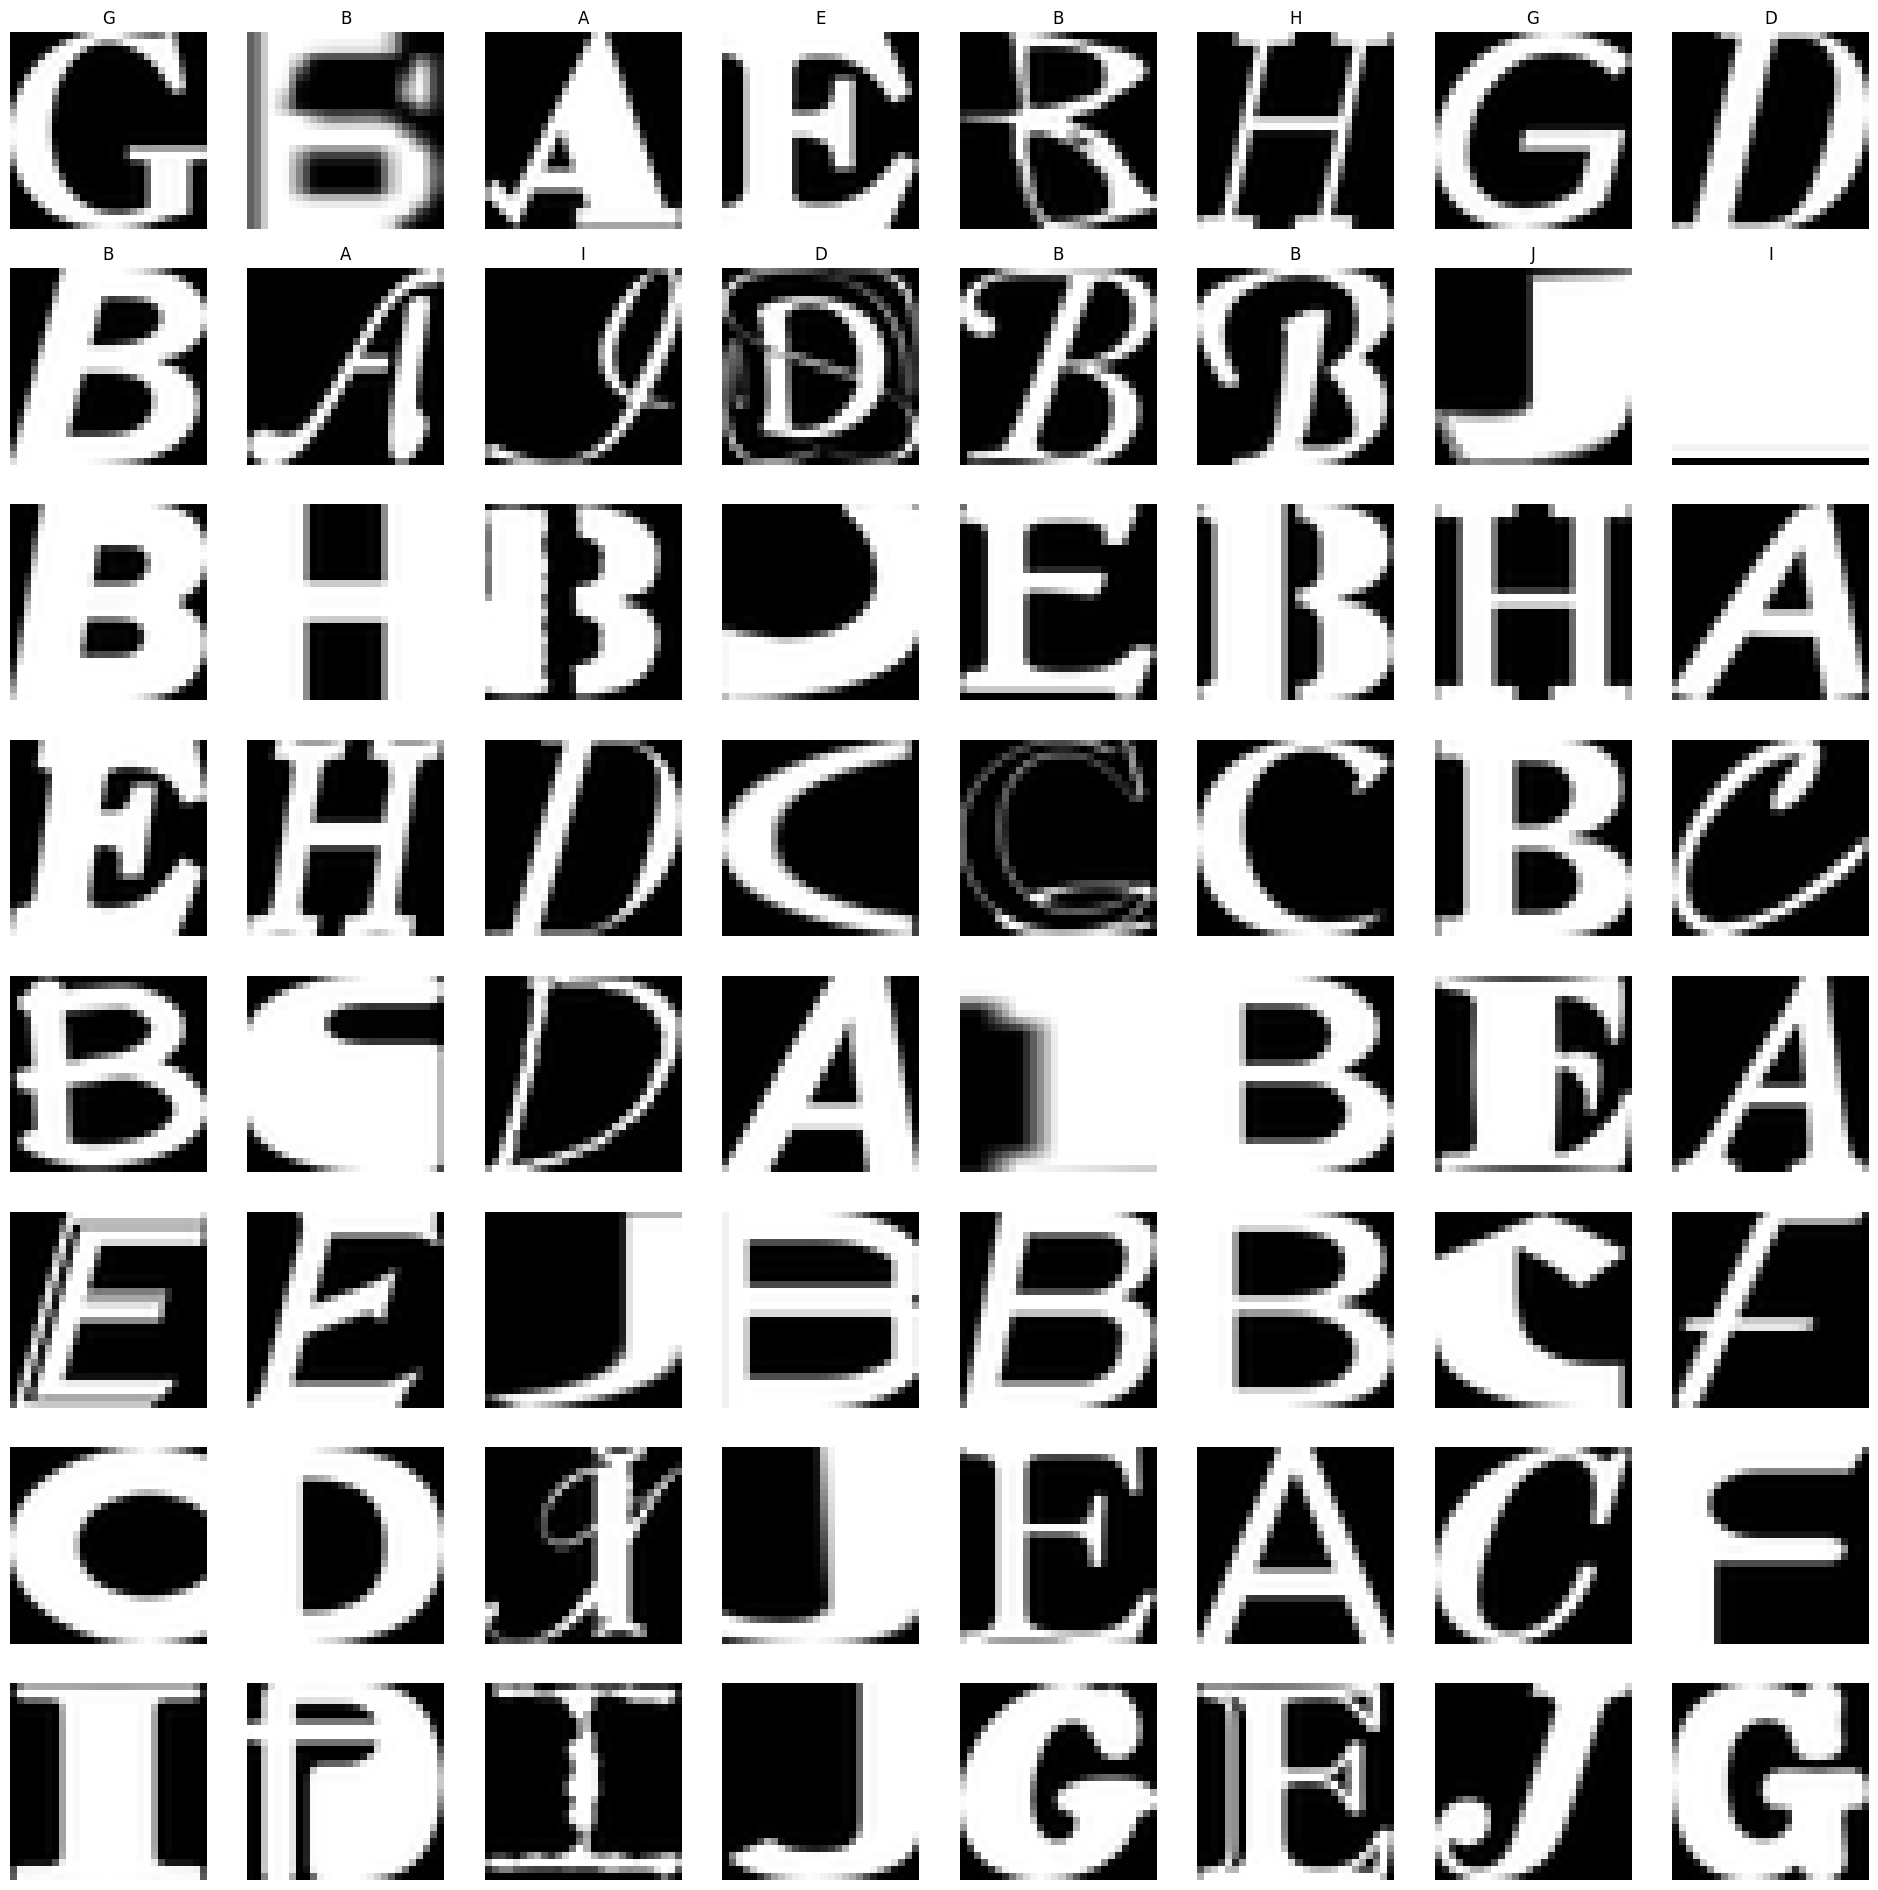

In [ ]:
show_images(xb, titles=titles)

# Learner

In [ ]:
class Learner:
    def __init__(self, dls, model, loss_func, opt_func, lr): fc.store_attr()
    
    def calc_stats(self):
        xb, yb = self.batch
        n = len(self.batch)
        self.losses.append(self.loss.item() * n)
        self.accuracy.append(accuracy(self.model(xb), yb).item() * n)
        self.ns.append(n)
        
    def one_batch(self):
        xb, yb = self.batch
        self.loss = self.loss_func(self.model(xb), yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
            
    def one_epoch(self, train):
        self.model.training = train
        dl = dls.train if train else dls.valid
        for self.num, self.batch in enumerate(dl): self.one_batch()
        print(self.epoch, self.model.training, sum(self.losses)/sum(self.ns), sum(self.accuracy)/sum(self.ns))
        
    def fit(self, epochs):
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.losses, self.accuracy, self.ns = [], [], []
              
        for self.epoch in range(epochs):
            self.one_epoch(True)
            self.one_epoch(False)
        

In [ ]:
ds

DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3745
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14979
    })
})

In [ ]:
xb[0].shape

torch.Size([784])

In [ ]:
torch.flatten(xb[0]).shape

torch.Size([784])

In [ ]:
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
tds = ds.with_transform(transformi)

In [ ]:
tds['train']['image'][0].shape, tds['train'][0]['label']

(torch.Size([784]), 6)

In [ ]:
m, nh = 784, 50

In [ ]:
model = nn.Sequential(
            nn.Linear(m, nh),
            nn.ReLU(),
            nn.Linear(nh, 10)
        )

In [ ]:
class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, bs, as_tuple=True):
        return cls(*[DataLoader(ds, bs, num_workers=4, collate_fn=collate_dict(ds)) for ds in dd.values()])

In [ ]:
dls = DataLoaders.from_dd(tds, bs)
xb, yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [ ]:
learn = Learner(dls, model, F.cross_entropy, SGD, 0.2)
learn.fit(10)

0 True 1.0980665804976124 0.7426168463997922
0 False 0.7928924392782101 0.7865710678149243
1 True 0.7408143380292752 0.8066210083178015
1 False 0.6575465995793034 0.818218054313238
2 True 0.6317646754718453 0.8284931034540651
2 False 0.5845641488264275 0.8394140169328573
3 True 0.5684540517089788 0.8459634537017814
3 False 0.5393119095888014 0.852576305215456
4 True 0.5275551673462275 0.8572920501473461
4 False 0.5075668967005854 0.8617385591373963
5 True 0.4982240805116118 0.8654999554819964
5 False 0.4842065381532421 0.8686965317074674
6 True 0.47634072781214004 0.8717375518003141
6 False 0.46677156835269507 0.873886689471318
7 True 0.45987819849188366 0.8765378752630952
7 False 0.45338264754086377 0.8778856003112128
8 True 0.4471690148418002 0.8802128502413822
8 False 0.4427033157762948 0.881049010556301
9 True 0.43702636924322674 0.8831178583852024
9 False 0.4341546040094857 0.883664772765977
